In [17]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [18]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [19]:
sv = Statevector.from_label('0' * n)

In [20]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        circuit.ry(params[i+2], i)

In [21]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        #circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        # cost += cost_estimate_sigmoid(prob, training_labels[i])
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 8  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,4)
    print(init_params)
    # train classifier
    init_params = np.random.uniform(-1,1,4)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'quantum_loss_easy_layer2h_%d.npy' %i
    f2 = 'opt_params_easy_layer2h_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

TypeError: 'module' object is not callable

In [22]:
loss_eqnn_d1 = np.load('quantum_loss_easy_layer2h_1.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'quantum_loss_easy_layer2h_1.npy'

In [15]:
loss_eqnn_d1.shape

NameError: name 'loss_eqnn_d1' is not defined

In [16]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'quantum_loss_easy_layer2h_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'quantum_loss_easy_layer2h_0.npy'

In [18]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training 2 Layers (Data Reuploading, Qubits = 2, Easy Model)')

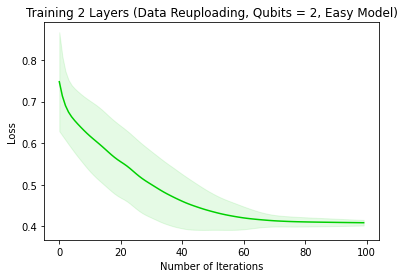

In [20]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)


plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training 2 Layers (Data Reuploading, Qubits = 2, Easy Model)")